In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from pathlib import Path
import cv2  # OpenCV

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available: []


In [2]:
# Set root directory
ROOT_DIR= os.path.join("..","data")

TRAIN_DIR= os.path.join(ROOT_DIR, "Train") 
TEST_DIR= os.path.join(ROOT_DIR, "Test")
META_DIR= os.path.join(ROOT_DIR, "Meta")
META_CSV= os.path.join(ROOT_DIR, "Meta.csv")
TEST_CSV= os.path.join(ROOT_DIR, "Test.csv")
TRAIN_CSV= os.path.join(ROOT_DIR, "Train.csv")



# Loading & Exploring Data 

In [3]:
class_names = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]

In [4]:
train_df= pd.read_csv(TRAIN_CSV) 
train_df['FullPath'] = train_df['Path'].apply(lambda x: os.path.join(ROOT_DIR, x))

train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,FullPath
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,..\data\Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,..\data\Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,..\data\Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,..\data\Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,..\data\Train/20/00020_00000_00004.png


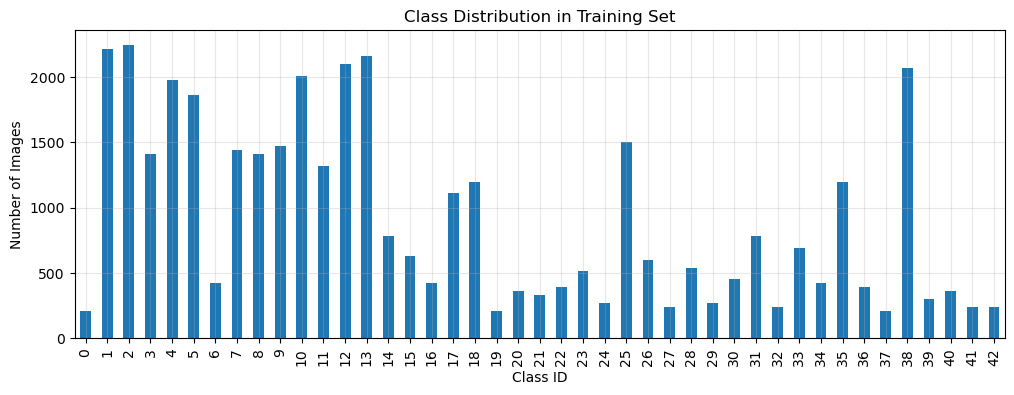

In [5]:
class_counts = train_df['ClassId'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
class_counts.plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# Load one image manually
sample_img_path = os.path.join(TRAIN_DIR, "0", "00000_00000_00000.png")  
img = plt.imread(sample_img_path)

print("Image shape:", img.shape)
print("Min pixel value:", img.min())
print("Max pixel value:", img.max())
print("Data type:", img.dtype)

Image shape: (30, 29, 3)
Min pixel value: 0.12156863
Max pixel value: 1.0
Data type: float32


Original image shape: (30, 29, 3)


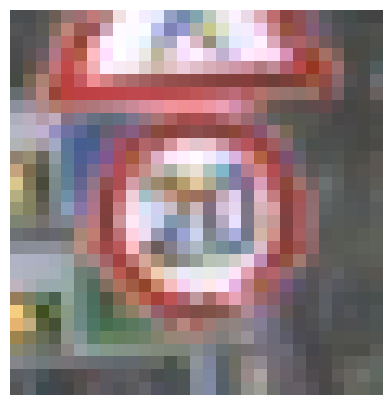

In [7]:
# Load one image manually (original size)
sample_img_path = os.path.join(TRAIN_DIR, "0", "00000_00000_00000.png")
img = plt.imread(sample_img_path)

print("Original image shape:", img.shape)
plt.figure(figsize=(5, 5))
plt.imshow(img)

plt.axis('off')
plt.show()

In [8]:
test_df = pd.read_csv(TEST_CSV)
ROOT_DIR_PATH = Path(ROOT_DIR)

test_df['FullPath'] = test_df['Path'].apply(lambda x: str(ROOT_DIR_PATH / x))


test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,FullPath
0,53,54,6,5,48,49,16,Test/00000.png,..\data\Test\00000.png
1,42,45,5,5,36,40,1,Test/00001.png,..\data\Test\00001.png
2,48,52,6,6,43,47,38,Test/00002.png,..\data\Test\00002.png
3,27,29,5,5,22,24,33,Test/00003.png,..\data\Test\00003.png
4,60,57,5,5,55,52,11,Test/00004.png,..\data\Test\00004.png


In [9]:
def transform_image(path, label, x1, y1, x2, y2):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    
    # Crop to ROI
    cropped = tf.image.crop_to_bounding_box(
        image,
        offset_height=tf.cast(y1, tf.int32),
        offset_width=tf.cast(x1, tf.int32),
        target_height=tf.cast(y2 - y1, tf.int32),
        target_width=tf.cast(x2 - x1, tf.int32)
    )
    
    # Resize to 32x32 and normalize
    resized = tf.image.resize(cropped, [32, 32])
    normalized = tf.cast(resized, tf.float32) / 255.0
    
    return normalized, label

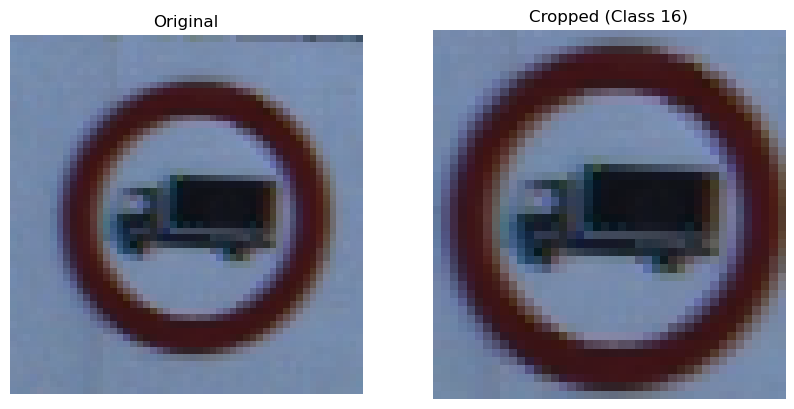

In [10]:

# Pick a sample
sample_idx = 0
row = test_df.iloc[sample_idx]

# Load original image
img_path = os.path.join(ROOT_DIR, row['Path'])
img = plt.imread(img_path)

# Crop to ROI
x1, y1, x2, y2 = row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']
cropped = img[y1:y2, x1:x2]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(cropped)
ax[1].set_title(f"Cropped (Class {row['ClassId']})")
ax[1].axis('off')

plt.show()

# Training

In [13]:

# Training dataset 
train_ds = tf.data.Dataset.from_tensor_slices((
    train_df['FullPath'].values,
    train_df['ClassId'].values,
    train_df['Roi.X1'].values,
    train_df['Roi.Y1'].values,
    train_df['Roi.X2'].values,
    train_df['Roi.Y2'].values
))

train_ds = train_ds.map(transform_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(32).shuffle(1000).prefetch(tf.data.AUTOTUNE)


train_split, val_split = train_test_split(train_df, test_size=0.2, stratify=train_df['ClassId'], random_state=123)

# Validation dataset 
val_ds = tf.data.Dataset.from_tensor_slices((
    val_split['FullPath'].values,
    val_split['ClassId'].values,
    val_split['Roi.X1'].values,
    val_split['Roi.Y1'].values,
    val_split['Roi.X2'].values,
    val_split['Roi.Y2'].values
))

val_ds = val_ds.map(transform_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)



test_ds = tf.data.Dataset.from_tensor_slices((
    test_df['FullPath'].values,
    test_df['ClassId'].values,
    test_df['Roi.X1'].values,
    test_df['Roi.Y1'].values,
    test_df['Roi.X2'].values,
    test_df['Roi.Y2'].values
))

test_ds = test_ds.map(transform_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [14]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 32, 32, 3)
Label batch shape: (32,)


In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(43, activation='softmax')  # 43 classes
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Done!")
model.summary()




Done!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,715 (487.17 KB)

 Trainable params: 124,715 (487.17 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
model_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

print("Training complete!")

Epoch 1/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.0647 - loss: 3.6413 - val_accuracy: 0.3219 - val_loss: 2.6085
Epoch 2/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.3268 - loss: 2.3745 - val_accuracy: 0.4431 - val_loss: 1.7151
Epoch 3/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.4123 - loss: 1.8070 - val_accuracy: 0.5091 - val_loss: 1.5152
Epoch 4/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.4989 - loss: 1.4960 - val_accuracy: 0.5953 - val_loss: 1.2534
Epoch 5/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.6427 - loss: 1.1254 - val_accuracy: 0.8208 - val_loss: 0.5858
Epoch 6/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.8108 - loss: 0.6324 - val_accuracy: 0.9032 - val_loss: 0.3865
Epoch 7/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.8998 - loss: 0.3501 - val_accuracy: 0.9313 - val_loss: 0.2306
Epoch 8/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9341 -

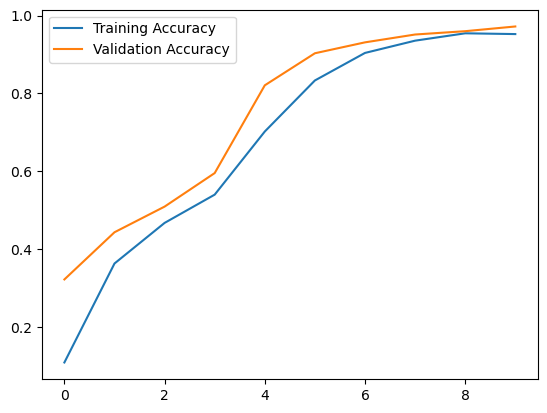

In [17]:
plt.plot(model_1.history['accuracy'], label='Training Accuracy')
plt.plot(model_1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Evaluation

In [18]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9209 - loss: 0.3203
Test Accuracy: 0.9196


# Bonus: Data Augmentation

In [24]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

# Apply augmentation to training dataset only
train_ds_aug = train_ds.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)



In [25]:
# Train with augmented training data
model_2 = model.fit(
    train_ds_aug,          
    validation_data=val_ds,
    epochs=10,
    verbose=1
)

Epoch 1/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.7605 - loss: 0.9509 - val_accuracy: 0.9239 - val_loss: 0.2389
Epoch 2/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 87s 48ms/step - accuracy: 0.9001 - loss: 0.3312 - val_accuracy: 0.9527 - val_loss: 0.1579
Epoch 3/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - accuracy: 0.9338 - loss: 0.2122 - val_accuracy: 0.9617 - val_loss: 0.1210
Epoch 4/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.9428 - loss: 0.1868 - val_accuracy: 0.9612 - val_loss: 0.1135
Epoch 5/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.9496 - loss: 0.1621 - val_accuracy: 0.9560 - val_loss: 0.1416
Epoch 6/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 76s 38ms/step - accuracy: 0.9613 - loss: 0.1236 - val_accuracy: 0.9726 - val_loss: 0.0868
Epoch 7/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - accuracy: 0.9705 - loss: 0.0946 - val_accuracy: 0.9759 - val_loss: 0.0775
Epoch 8/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 97s 51ms/step - accuracy: 0.9719 -

# Bonus: Transfer Learning

In [32]:
def resize_image(image, label):
    # Resize to 224x224
    image = tf.image.resize(image, [224, 224])
    return image, label

train_ds_mobilenet = train_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_mobilenet = val_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_mobilenet = test_ds.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

trans_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  
    include_top=False,
    weights='imagenet'
)

# Freeze weights 
trans_model.trainable = False

print("MobileNetV2 model loaded!")

MobileNetV2 model loaded!


In [33]:
model_transfer = tf.keras.Sequential([
    trans_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(43, activation='softmax')
])

model_transfer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Transfer learning model built!")
model_transfer.summary()

Transfer learning model built!


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          55,083 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [34]:

model_3 = model_transfer.fit(
    train_ds_mobilenet,             
    validation_data=val_ds_mobilenet,
    epochs=10,
    verbose=1
)

print("Transfer learning model training complete!")

Epoch 1/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 908s 706ms/step - accuracy: 0.2900 - loss: 3.0072 - val_accuracy: 0.6098 - val_loss: 1.2351
Epoch 2/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 521s 420ms/step - accuracy: 0.6279 - loss: 1.1974 - val_accuracy: 0.7522 - val_loss: 0.8184
Epoch 3/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 589s 475ms/step - accuracy: 0.7221 - loss: 0.8958 - val_accuracy: 0.7893 - val_loss: 0.6923
Epoch 4/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 545s 439ms/step - accuracy: 0.7569 - loss: 0.7776 - val_accuracy: 0.8194 - val_loss: 0.5718
Epoch 5/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 529s 426ms/step - accuracy: 0.7758 - loss: 0.6985 - val_accuracy: 0.8243 - val_loss: 0.5553
Epoch 6/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 489s 394ms/step - accuracy: 0.8046 - loss: 0.6224 - val_accuracy: 0.8392 - val_loss: 0.4917
Epoch 7/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 461s 371ms/step - accuracy: 0.8264 - loss: 0.5317 - val_accuracy: 0.8715 - val_loss: 0.4054
Epoch 8/10
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 460s 370ms/step - ac

In [ ]:
test_loss_cnn, test_acc_cnn = model.evaluate(test_ds, verbose=0)
print(f"Custom CNN Test Accuracy: {test_acc_cnn:.4f}")

test_loss_transfer, test_acc_transfer = model_transfer.evaluate(test_ds_mobilenet, verbose=0)
print(f"MobileNet Test Accuracy: {test_acc_transfer:.4f}")

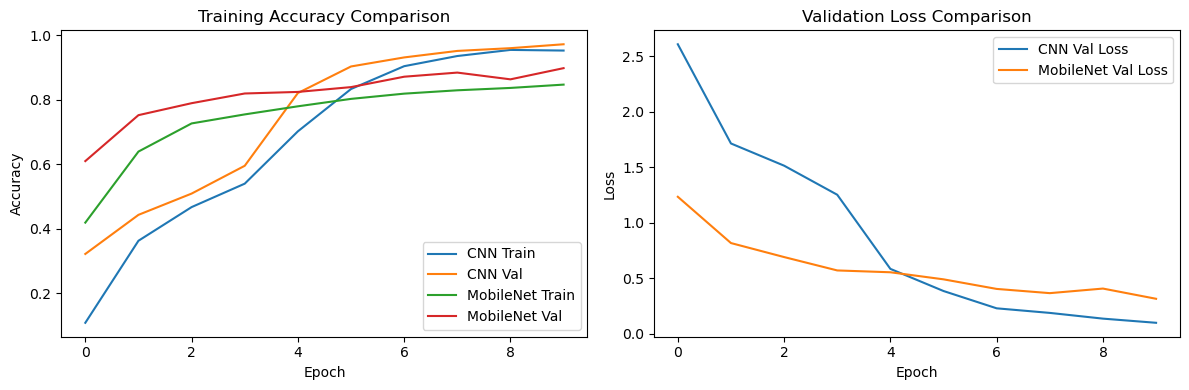

In [36]:
plt.figure(figsize=(12, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(model_1.history['accuracy'], label='CNN Train')
plt.plot(model_1.history['val_accuracy'], label='CNN Val')
plt.plot(model_3.history['accuracy'], label='MobileNet Train')
plt.plot(model_3.history['val_accuracy'], label='MobileNet Val')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(model_1.history['val_loss'], label='CNN Val Loss')
plt.plot(model_3.history['val_loss'], label='MobileNet Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()